In [48]:
import numpy as np
import pandas as pd
import pims
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from colormath.color_objects import XYZColor, sRGBColor
from colormath.color_conversions import convert_color
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

tab10 = plt.get_cmap('tab10')
cmap =  plt.get_cmap('viridis')

%config InlineBackend.figure_format='retina'
%matplotlib inline

plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Read data

In [1]:
## Read csv file containing RGB values of capillary images with unknown pH values

In [49]:
df = pd.read_csv('.csv')
df.head()

,Unnamed: 0,bicarbonate,R,G,B
0,0,1.0,128.330141,124.857243,99.603990
1,1,2.0,129.726733,126.286001,99.674976
2,2,3.0,129.572655,126.104204,99.664930
3,3,4.0,123.960978,121.062458,93.649545
4,4,5.0,123.940980,121.132275,93.588663


In [ ]:
## Read csv file containing RGB values of capillary images with known pH values

In [51]:
df_calibration = pd.read_csv('.csv')
df_calibration.head()

,Unnamed: 0,pH,R,G,B
0,0,7.0,148.412108,140.390083,99.179233
1,1,7.0,148.847767,140.975134,99.867223
2,2,7.0,148.674228,140.825201,99.624101
3,3,7.5,133.932627,127.693807,93.218343
4,4,7.5,138.562538,132.246749,97.994510


# Compute XYZ color

In [52]:
# add an empty columns
df['X'] = np.nan
df['Y'] = np.nan
df['Z'] = np.nan
df['x_color'] = np.nan
df['y_color'] = np.nan

for index, row in df.iterrows():
    rgb = sRGBColor(row['R']/255, row['G']/255, row['B']/255)
    xyz = convert_color(rgb, XYZColor, target_illuminant='d50')
    df.at[index, 'X'] = xyz.xyz_x
    df.at[index, 'Y'] = xyz.xyz_y
    df.at[index, 'Z'] = xyz.xyz_z
    S = xyz.xyz_x + xyz.xyz_y + xyz.xyz_z
    df.at[index, 'x_color'] = xyz.xyz_x / S
    df.at[index, 'y_color'] = xyz.xyz_y / S

In [53]:
# add an empty columns
df_calibration['X'] = np.nan
df_calibration['Y'] = np.nan
df_calibration['Z'] = np.nan
df_calibration['x'] = np.nan
df_calibration['y'] = np.nan

for index, row in df_calibration.iterrows():
    rgb = sRGBColor(row['R']/255, row['G']/255, row['B']/255)
    xyz = convert_color(rgb, XYZColor, target_illuminant='d50')
    df_calibration.at[index, 'X'] = xyz.xyz_x
    df_calibration.at[index, 'Y'] = xyz.xyz_y
    df_calibration.at[index, 'Z'] = xyz.xyz_z
    S = xyz.xyz_x + xyz.xyz_y + xyz.xyz_z
    df_calibration.at[index, 'x'] = xyz.xyz_x / S
    df_calibration.at[index, 'y'] = xyz.xyz_y / S

# Chromaticity

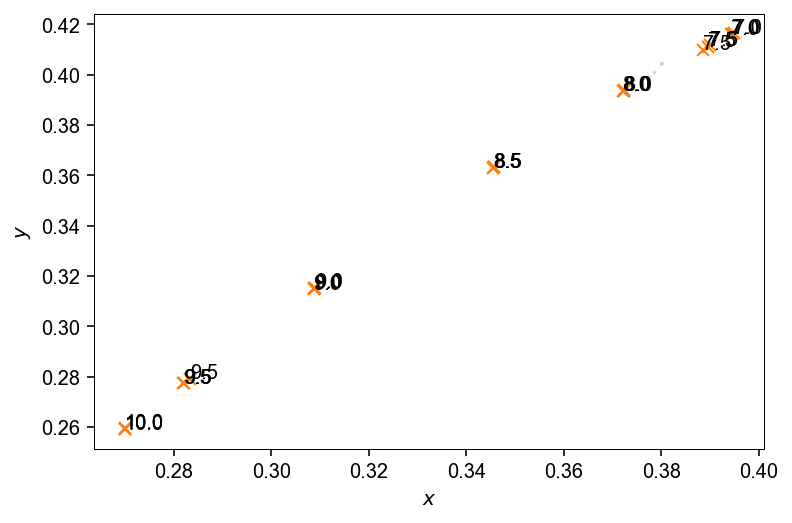

In [54]:
plt.plot(df['x_color'].values, df['y_color'].values, 'o', alpha=0.1, ms=1)
plt.plot(df_calibration['x'].values, df_calibration['y'].values, 'x')

for i, pH in enumerate(df_calibration['pH'].values):
    plt.annotate('%.1f'%pH, (df_calibration['x'].values[i], df_calibration['y'].values[i]))
    
plt.ylabel('$y$')
plt.xlabel('$x$');

# Calibrate

Infer the coefficients $\mathbf{X}=\{X_0,X_1,X_2,Y_0,Y_1,Y_2\}$ from the calibration data $\{x_j,y_j,\delta_j\}$.  This is a linear regression problem.

In [55]:
pKa = 8.94 # reported value

# calibration data
xc = df_calibration['x'].values
yc = df_calibration['y'].values
deltac = 1 / (1 + 10**(pKa - df_calibration['pH'].values))
M = xc.shape[0]

## linear regression
# design matrix: M x 3
X = np.ones((M,3))
X[:,1] = deltac
X[:,2] = deltac**2

# using scipy
regx = LinearRegression(fit_intercept=False).fit(X, xc)
regy = LinearRegression(fit_intercept=False).fit(X, yc)
X0, X1, X2 = regx.coef_
Y0, Y1, Y2 = regy.coef_

# noise estimate
x_fit = regx.predict(X)
y_fit = regy.predict(X)
sigmac2 = np.sum((xc-x_fit)**2 + (yc-y_fit)**2) / (2*M)
print('noise magnitude sigma = %f'%np.sqrt(sigmac2))

# covariance
invSigma = X.T@X / sigmac2
Sigma = np.linalg.inv(invSigma)

print('X0 = %f +/- %f'%(X0, np.sqrt(Sigma[0,0])))
print('X1 = %f +/- %f'%(X1, np.sqrt(Sigma[1,1])))
print('X2 = %f +/- %f'%(X2, np.sqrt(Sigma[2,2])))
print('Y0 = %f +/- %f'%(Y0, np.sqrt(Sigma[0,0])))
print('Y1 = %f +/- %f'%(Y1, np.sqrt(Sigma[1,1])))
print('Y2 = %f +/- %f'%(Y2, np.sqrt(Sigma[2,2])))

noise magnitude sigma = 0.001302
X0 = 0.395379 +/- 0.000522
X1 = -0.203821 +/- 0.003547
X2 = 0.074538 +/- 0.003840
Y0 = 0.417996 +/- 0.000522
Y1 = -0.221124 +/- 0.003547
Y2 = 0.053453 +/- 0.003840


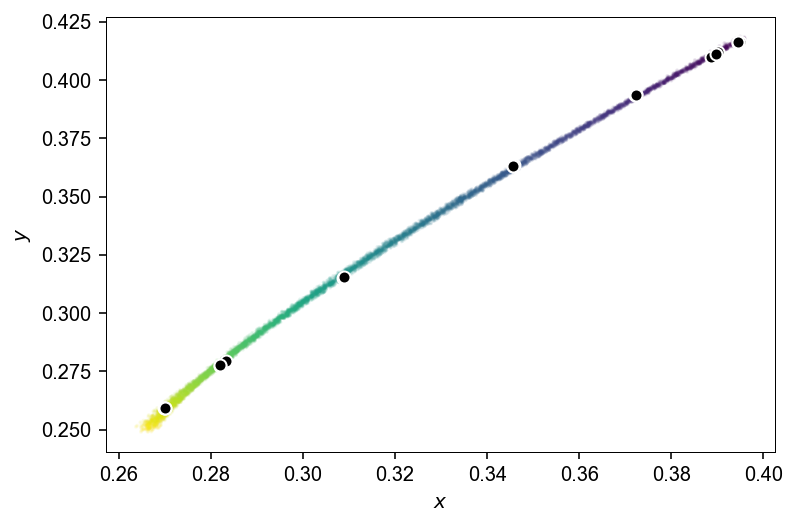

In [56]:
# simulated data
samples = 80
points = 81 # per sample
Xsamples = np.random.multivariate_normal(regx.coef_, Sigma, samples)
Ysamples = np.random.multivariate_normal(regy.coef_, Sigma, samples)
delta = np.random.rand(points,samples)
xsamples = Xsamples[None,:,0]*delta**0 + Xsamples[None,:,1]*delta**1 + Xsamples[None,:,2]*delta**2
ysamples = Ysamples[None,:,0]*delta**0 + Ysamples[None,:,1]*delta**1 + Ysamples[None,:,2]*delta**2

plt.scatter(np.ravel(xsamples), np.ravel(ysamples), c=np.ravel(delta),
           s = 1, alpha = 0.1);
plt.plot(df_calibration['x'].values, df_calibration['y'].values, 'ko', mec='w')

plt.ylabel('$y$')
plt.xlabel('$x$');

# Estimate deprotonation $\hat{\delta}$

Given the coefficients $\mathbf{X}$, the log-posterior for the deprotonation fraction is 

\begin{equation}
     \ln p(\delta\mid x,y , \mathbf{X}) = \text{constant} - \frac{1}{2 \sigma^2} \Big[ \big (x - (X_0 + X_1 \delta + X_2 \delta^2)\big)^2  + \big(y - (Y_0 + Y_1 \delta + Y_2 \delta^2)\big)^2 \Big]
\end{equation}

This is a quartic polynomial.  Differentiating yields a cubic polynomial.  We want the relevant root of this polynomial.

In [57]:
def calc_delta_hat(x,y,X) : 
    X0,X1,X2,Y0,Y1,Y2 = X

    # most probable delta (solve this 3th order polynomial)
    dp = np.zeros((4,)) # cubic coefficients
    dp[0] = -2*(X2**2 + Y2**2) 
    dp[1] = -3*(X1*X2 + Y1*Y2)
    dp[2] = -(X1**2 + 2*X2*(X0-x) + Y1**2 + 2*Y2*(Y0-y)) 
    dp[3] = -(X1*(X0-x) + Y1*(Y0-y)) 
    out = np.roots(dp)
    
    # differentiate
    ddp = np.polyval(np.polyder(dp), out)
    
    # select maximum
    idx = (ddp.real < 0) # should be a maximum
    dist2 = (out - 0.5)**2 # should be in the range from 0-1
    j = np.argmin(dist2[idx])
    return out[idx].real[j]

In [58]:
xk = df['x_color'].values
yk = df['y_color'].values
deltak = np.zeros(xk.shape)

X = np.array([X0,X1,X2,Y0,Y1,Y2])
for k in range(xk.shape[0]) : 
    deltak[k] = calc_delta_hat(xk[k],yk[k],X)

Text(0, 0.5, '$y$')

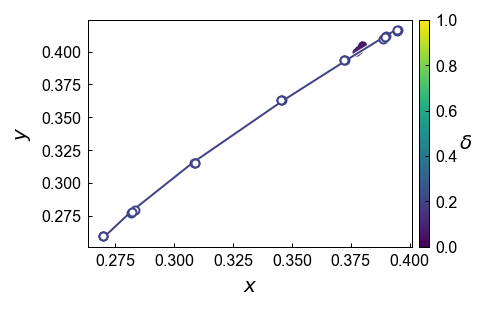

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

## declare figure 
fig,ax = plt.subplots()

# sizing & plot parameters
cm = 2.54
width = 2 * 6 / cm
height = 2 * 4 / cm
fig.set_size_inches(width, height)
ax.set_position([0.25, 0.25, 0.5, 0.5])

sc = ax.scatter(xk, yk, c=deltak, vmax=1, vmin=0, s=5, linewidths=2)
ax.plot(np.sort(x_fit),np.sort(y_fit),'w-', lw=2)
ax.plot(np.sort(x_fit),np.sort(y_fit),'-', lw=1, color=cmap(0.2))

ax.plot(df_calibration['x'].values, df_calibration['y'].values, 
        'o', color=cmap(0.2), ms=4, mew=1, mfc='w')

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad="2%")
cbar = plt.colorbar(sc, cax=cax)
cax.set_yticks(np.array([0,0.2,0.4,0.6,0.8, 1]))
cax.set_ylim(0,1)
cbar.set_label('$\delta$', fontsize=10, rotation=0)
cax.tick_params(direction="in", length=2, width = 0.5, axis='both', which='major', labelsize=8)

ax.tick_params(direction="in", length=2, width = 0.5, axis='both', which='major', labelsize=8)
ax.set_xlabel('$x$', fontsize=10)
ax.set_ylabel('$y$', fontsize=10)

#plt.savefig('23.12.22-23 capillary data vs 24.08.21 calibration both settings gamma = 0.png', dpi=600)
# plt.savefig('chamber1.pdf', dpi=600)

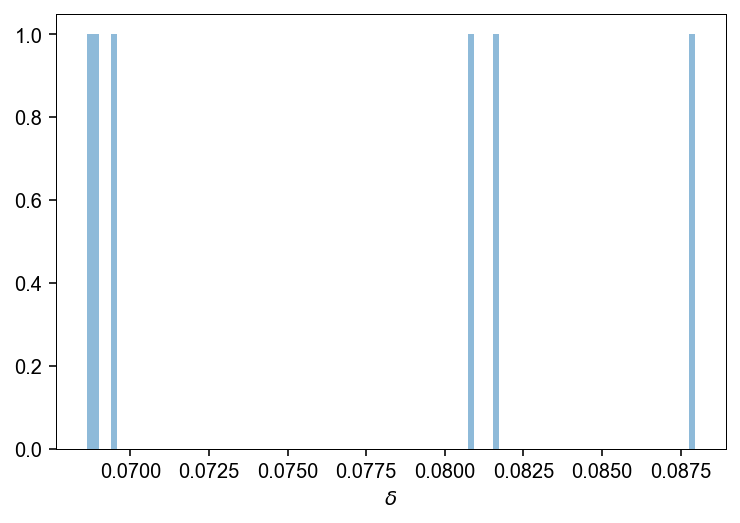

In [60]:
bins = np.linspace(deltak.min(), deltak.max(),100)
plt.hist(deltak, bins=bins, alpha=0.5)
plt.xlabel('$\delta$');

## Estimate $\sigma^2$

Error based on capillary = 0.001686
Error based on calibration = 0.001302
Total error = 0.002130


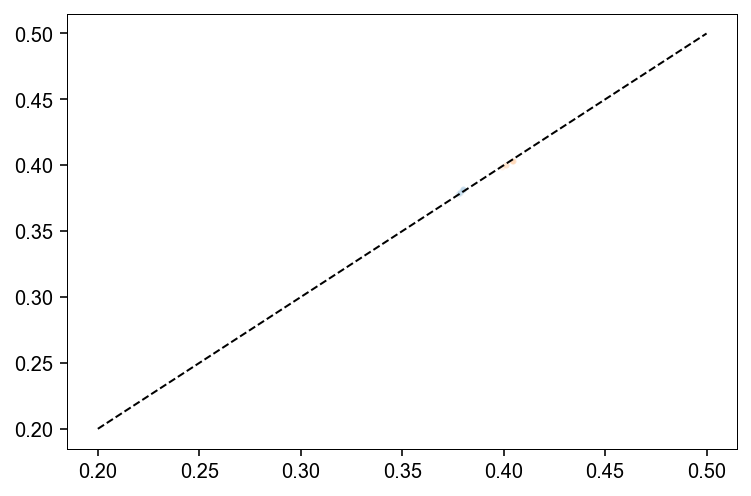

In [61]:
idx = (deltak == deltak)
plt.plot(xk[idx], X0 + X1*deltak[idx] + X2*deltak[idx]**2, '.', alpha=0.1, mew=0)
plt.plot(yk[idx], Y0 + Y1*deltak[idx] + Y2*deltak[idx]**2, '.', alpha=0.1, mew=0)
plt.plot(np.linspace(0.2,0.5,100), np.linspace(0.2,0.5,100), 'k--', lw=1)
    
sigma2 = np.nanmean( (xk - (X0 + X1*deltak + X2*deltak**2))**2 + (yk - (Y0 + Y1*deltak + Y2*deltak**2))**2 )
print('Error based on capillary = %f'%np.sqrt(sigma2))      
print('Error based on calibration = %f'%np.sqrt(sigmac2))
sigma2_tot = sigma2 + sigmac2
print('Total error = %f'%np.sqrt(sigma2_tot))    

# pH vs time with uncertainty

In [62]:
# Uncertainty estimate
p = np.zeros((3,deltak.shape[0])) 
p[0,:] = -6*(X2**2 + Y2**2) / sigma2_tot
p[1,:] = -6*(X1*X2 + Y1*Y2) / sigma2_tot
p[2,:] = -(X1**2 + 2*X2*(X0-xk) + Y1**2 + 2*Y2*(Y0-yk)) / sigma2_tot
epsilonk = np.sqrt(-1 / np.polyval(p, deltak) )

df['delta'] = deltak
df['epsilon'] = epsilonk

# let's omit values certain values
idx = (deltak > 0) & (deltak < 1)
pH = np.zeros(deltak.shape)
pH[idx] = pKa + np.log(deltak[idx]/(1 - deltak[idx])) / np.log(10)
pH[np.logical_not(idx)] = np.nan

# let's omit values certain values
idx = (deltak - epsilonk > 0) & (deltak + epsilonk < 1)
pHlow = np.zeros(deltak.shape)
pHhigh = np.zeros(deltak.shape)
pHlow[idx] = pKa + np.log((deltak[idx]-epsilonk[idx])/(1 - deltak[idx] + epsilonk[idx])) / np.log(10)
pHhigh[idx] = pKa + np.log((deltak[idx]+epsilonk[idx])/(1 - deltak[idx] - epsilonk[idx])) / np.log(10)
pHlow[np.logical_not(idx)] = np.nan
pHhigh[np.logical_not(idx)] = np.nan

df['pH'] = pH
df['pHlow'] = pHlow
df['pHhigh'] = pHhigh

In [63]:
df.to_csv('.csv')

In [64]:
df

,bicarbonate,R,G,B,X,Y,Z,x_color,y_color,delta,epsilon,pH,pHlow,pHhigh
0,1.0,128.330141,124.857243,99.603990,0.191510,0.202612,0.113158,0.377522,0.399409,0.087973,0.007475,7.924342,7.882234,7.963332
1,2.0,129.726733,126.286001,99.674976,0.195740,0.207415,0.113859,0.378596,0.401179,0.080855,0.007441,7.884320,7.838892,7.926083
2,3.0,129.572655,126.104204,99.664930,0.195236,0.206820,0.113769,0.378493,0.400950,0.081691,0.007445,7.889187,7.844180,7.930600
3,4.0,123.960978,121.062458,93.649545,0.177428,0.188768,0.100723,0.379997,0.404285,0.069572,0.007387,7.813754,7.761572,7.861039
4,5.0,123.940980,121.132275,93.588663,0.177467,0.188914,0.100638,0.380000,0.404510,0.068985,0.007384,7.809797,7.757200,7.857417
5,6.0,123.399468,120.568607,93.095712,0.175732,0.187048,0.099557,0.380094,0.404571,0.068611,0.007382,7.807260,7.754393,7.855097
